In [107]:
from IPython import parallel
c = parallel.Client()
view = c.load_balanced_view()

In [108]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_context('talk')
sns.set_palette('hls', n_colors=7)
import zipline
print zipline.__version__

import pytz
from datetime import datetime

from zipline.utils.factory import load_bars_from_yahoo

# Load data manually from Yahoo! finance
start = datetime(2009, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2012, 1, 1, 0, 0, 0, 0, pytz.utc)
large_cap = load_bars_from_yahoo(stocks=['CERN', 'DLTR', 'ROST', 'SBUX'], 
                            start=start,
                            end=end)

# Taken from http://www.forbes.com/sites/brettnelson/2011/10/19/fifteen-small-company-stocks-to-buy-right-now/
small_cap = load_bars_from_yahoo(stocks=['HMSY', 'BWLD', 'IRBT', 'IPGP'], 
                            start=start,
                            end=end)

0.7.0
CERN
DLTR
ROST
SBUX
HMSY
BWLD
IRBT
IPGP


In [109]:
(large_cap.loc[:, :, 'volume'].mean() * large_cap.loc[:, :, 'price'].mean()).mean()

126731320.05025575

In [110]:
(small_cap.loc[:, :, 'volume'].mean().mean() * small_cap.loc[:, :, 'price'].mean()).mean()

11952436.55884986

In [112]:
%%px --local

import zipline.utils.factory as factory
from zipline.algorithm import TradingAlgorithm
from zipline.api import order_target_percent, record, symbol, history, add_history, get_open_orders, get_datetime, set_slippage
from zipline.finance.slippage import VolumeShareSlippage
import numpy as np
import math
from pytz import timezone
from zipline.api import symbols

def initialize(context):
    set_slippage(VolumeShareSlippage(volume_limit=0.5,
                                     price_impact=1.5))
    context.eps = 1 # change epsilon here
    context.init = False
    context.previous_datetime = None
    context.i = 0
    
    add_history(30, '1d', 'price')
    add_history(30, '1d', 'volume')
    
def handle_data(context, data):
    context.i += 1
    if context.i < 30: return
    
    current_datetime = get_datetime().astimezone(timezone('US/Eastern'))
    
    cash = context.portfolio.cash
    record(cash=cash)
            
    if not context.init:
        context.stocks = data.keys()
    
        context.m = len(context.stocks)
        context.b_t = np.ones(context.m) / context.m
        # Equal weighting portfolio
        for stock, percent in zip(context.stocks, context.b_t):
            order_target_percent(stock, percent)
        context.init = True
      
    # only execute algorithm once per day
    if context.previous_datetime != None:
        if current_datetime.day != context.previous_datetime.day:
            new_day = True
            algo_executed = False
        else:
            new_day = False
    else:
        new_day = False
        algo_executed = True
        
    context.previous_datetime = current_datetime
    
    if not new_day or algo_executed == True:
        return
        
    # skip tic if any orders are open or any stocks did not trade
    for stock in context.stocks:
        if bool(get_open_orders(stock)) or data[stock].datetime < get_datetime():
            return
        
    # compute current portfolio allocations
    for i, stock in enumerate(context.stocks):
        context.b_t[i] = context.portfolio.positions[stock].amount*data[stock].price
        
    # Bring portfolio vector to unit length
    context.b_t = context.b_t / np.sum(context.b_t)

    # Compute new portfolio weights according to OLMAR algo.
    b_norm = np.zeros((context.m, 28))
    x_tilde = np.zeros((context.m, 28))
    for k in range(28):
        b_norm[:,k],x_tilde[:,k] = olmar(context,k+3)
        
    s = np.zeros(28)
    b_norm_opt = np.zeros(context.m)
    s_sum = 0
    for k in range(28):
        s[k] = np.dot(b_norm[:,k],x_tilde[:,k])
        b_norm[:,k] = np.multiply(s[k],b_norm[:,k])
        b_norm_opt += b_norm[:,k]
        s_sum += s[k]
        
    b_norm_opt = np.divide(b_norm_opt,s_sum)
    
    #print b_norm_opt
    
    # Rebalance Portfolio
    for stock, percent in zip(context.stocks, b_norm_opt):
        order_target_percent(stock, percent)
    
    algo_executed = True

def olmar(context,window):
    """Logic of the olmar algorithm.

    :Returns: b_norm : vector for new portfolio
    """
    
    # get history -- prices and volums of the last 5 days (at close)
    p = history(30, '1d', 'price')
    v = history(30, '1d', 'volume')
    
    prices = p.ix[30-window:-1]
    volumes = v.ix[30-window:-1]
    
    # find relative moving volume weighted average price for each secuirty
    x_tilde = np.zeros(context.m)
    for i, stock in enumerate(context.stocks):
        vwa_price = np.dot(prices[stock], volumes[stock]) / np.sum(volumes[stock])
        x_tilde[i] = vwa_price/prices[stock].ix[-1]
    
    ###########################
    # Inside of OLMAR (algo 2)
    x_bar = x_tilde.mean()

    # Calculate terms for lambda (lam)
    dot_prod = np.dot(context.b_t, x_tilde)
    num = context.eps - dot_prod
    denom = (np.linalg.norm((x_tilde-x_bar)))**2

    # test for divide-by-zero case
    if denom == 0.0:
        lam = 0 # no portolio update
    else:     
        lam = max(0, num/denom)
    
    b = context.b_t + lam*(x_tilde-x_bar)

    b_norm = simplex_projection(b)
    
    return b_norm,x_tilde

def simplex_projection(v, b=1):
    v = np.asarray(v)
    p = len(v)

    # Sort v into u in descending order
    v = (v > 0) * v
    u = np.sort(v)[::-1]
    sv = np.cumsum(u)

    rho = np.where(u > (sv - b) / np.arange(1, p+1))[0][-1]
    theta = np.max([0, (sv[rho] - b) / (rho+1)])
    w = (v - theta)
    w[w<0] = 0
    return w

In [113]:
def run_algo(data, capital_base):
    sim_params = factory.create_simulation_parameters(capital_base=capital_base)

    algo_obj = TradingAlgorithm(initialize=initialize,
                                handle_data=handle_data,
                                sim_params=sim_params)
    
    perf = algo_obj.run(data)
    return perf

# Run large cap universe

In [141]:
test_vals = [1e3, 1e4, 1e5, 5e5, 1e6, 5e6, 1e7]

In [142]:
perfs_lc = view.map_async(run_algo, [large_cap]*len(test_vals), test_vals)
perfs_lc.wait_interactive()

   7/7 tasks finished after   71 s
done


In [143]:
perfs_lc = perfs_lc.get()

# Run small cap universe

In [144]:
perfs_sc = view.map_async(run_algo, [small_cap]*len(test_vals), test_vals)
perfs_sc.wait_interactive()

   7/7 tasks finished after   71 s
done


In [145]:
perfs_sc = perfs_sc.get()

# Analyse results

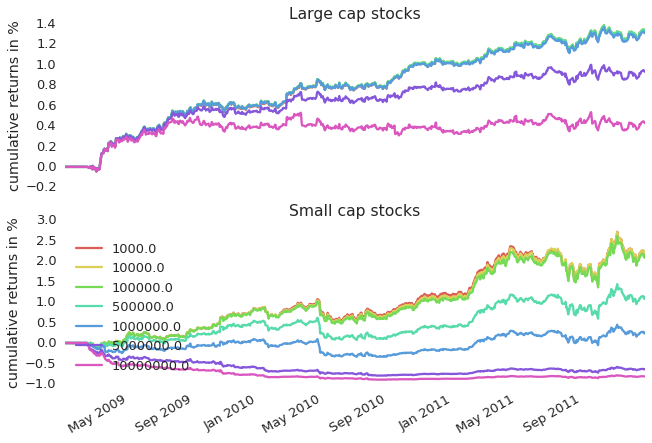

In [155]:
ax1 = plt.subplot(2, 1, 1)
results = [(cpt_base, np.cumsum(np.log(1 + perf.returns))) for cpt_base, perf in zip(test_vals, perfs_lc)]
for capital, rets in results:
    rets.plot(ax=ax1, label=capital)
plt.ylabel('cumulative returns in %')
plt.title('Capacity analysis\nIdentical algorithm with different capital bases')
plt.title('Large cap stocks')
ax1.set_xticks([])

ax2 = plt.subplot(2, 1, 2)
results = [(cpt_base, np.cumprod((1 + perf.returns)) - 1) for cpt_base, perf in zip(test_vals, perfs_sc)]
for capital, rets in results:
    rets.plot(ax=ax2, label=capital, sharex=ax1)
plt.legend(loc=3)
plt.ylabel('cumulative returns in %')
plt.title('Small cap stocks')
plt.savefig('cap_rets.png')

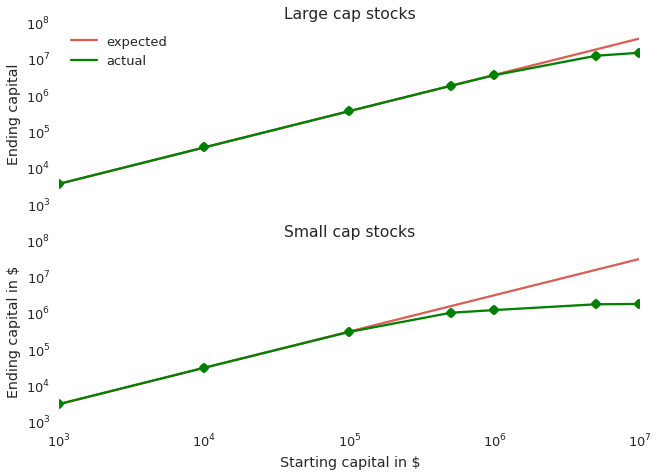

In [152]:
ax1 = plt.subplot(2, 1, 1)

results = np.array([(cpt_base, perf.iloc[-1].portfolio_value) for cpt_base, perf in zip(test_vals, perfs_lc)])
slope = (results[1, 1] - results[0, 1]) / (results[1, 0] - results[0, 0])
intercept = results[0, 1] - results[0, 0] * slope
y = slope * test_vals[-1] + intercept
ax1.loglog((test_vals[0], test_vals[-1]), (results[0, 1], y), label='expected')
ax1.loglog(results[:, 0], results[:, 1], 'g', label='actual')
ax1.loglog(results[:, 0], results[:, 1], 'go')
#plt.xlabel('Starting capital')
plt.ylabel('Ending capital')
plt.legend(loc=0)
plt.title('Large cap stocks')
ax1.set_xticks([])

ax2 = plt.subplot(2, 1, 2)
results = np.array([(cpt_base, perf.iloc[-1].portfolio_value) for cpt_base, perf in zip(test_vals, perfs_sc)])
slope = (results[1, 1] - results[0, 1]) / (results[1, 0] - results[0, 0])
intercept = results[0, 1] - results[0, 0] * slope
y = slope * test_vals[-1] + intercept
ax2.loglog((test_vals[0], test_vals[-1]), (results[0, 1], y), label='expected')
ax2.loglog(results[:, 0], results[:, 1], 'g', label='actual')
ax2.loglog(results[:, 0], results[:, 1], 'go')
plt.xlabel('Starting capital in $')
plt.ylabel('Ending capital in $')
plt.title('Small cap stocks')
plt.savefig('cap_capital.png')

In [121]:
large_cap

<class 'pandas.core.panel.Panel'>
Dimensions: 4 (items) x 756 (major_axis) x 6 (minor_axis)
Items axis: CERN to SBUX
Major_axis axis: 2009-01-02 00:00:00+00:00 to 2011-12-30 00:00:00+00:00
Minor_axis axis: open to price

In [148]:
small_cap.loc['IRBT', perfs_sc[0].transactions.iloc[30][0]['dt']] # + pd.Timedelta('1d')]

open          8.35
high          8.35
low           7.70
close         7.98
volume    97800.00
price         7.98
Name: 2009-02-17 00:00:00+00:00, dtype: float64

In [123]:
pd.Series({p['sid']: p['price'] for p in perfs_sc[3].transactions.iloc[30]})['IRBT']

9.193332196356657

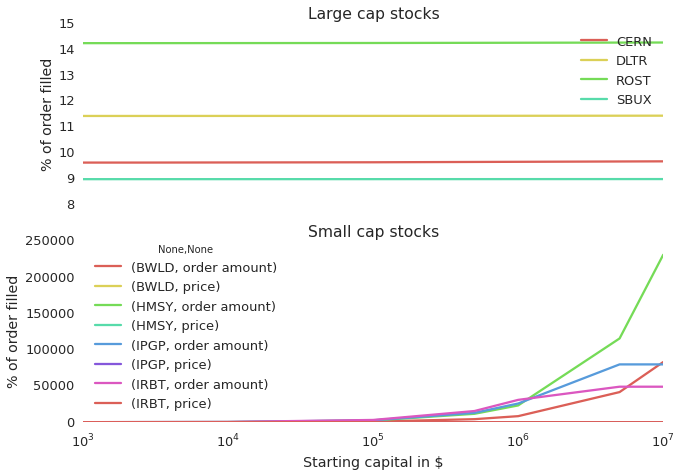

In [162]:
ax1 = plt.subplot(2, 1, 1)
price = {}
for i in range(len(test_vals)):
    price[test_vals[i]] = pd.Series({p['sid']: p['price'] for p in perfs_lc[i].transactions.iloc[30]})
    
prices = pd.concat(price).unstack()
prices.plot(ax=ax1)
#plt.xlabel('Starting capital in $')
plt.ylabel('% of order filled')
plt.title('Large cap stocks')
ax1.set_xticks([])

ax2 = plt.subplot(2, 1, 2)
price = {}
for i in range(len(test_vals)):
    price[test_vals[i]] = pd.DataFrame({p['sid']: {'price': p['price'], 'order amount': p['amount']} for p in perfs_sc[i].transactions.iloc[30]})
prices = pd.concat(price).unstack()
prices.plot(ax=ax2, logx=True)
plt.xlabel('Starting capital in $')
plt.ylabel('% of order filled')
plt.title('Small cap stocks')
#plt.savefig('cap_filled.png')

In [166]:
df = prices['IRBT']
#df['price'] = ((df['price'] / df.loc[1000, 'price']) - 1)
df.index.name = 'Capital'
df

,order amount,price
Capital,,
1000,30,8.010001
10000,307,8.010118
100000,3075,8.021833
500000,15375,8.305833
1000000,30750,9.193332
5000000,48900,11.002500
10000000,48900,11.002500


In [168]:
test_vals

[1000.0, 10000.0, 100000.0, 500000.0, 1000000.0, 5000000.0, 10000000.0]

In [172]:
txns

,BWLD,HMSY,IPGP,IRBT
1000,0.975610,1.000000,0.972763,0.977199
10000,1.000000,1.000000,1.000000,1.000000
100000,1.010976,1.003478,1.000778,1.001629
500000,0.505732,0.501826,0.500389,0.500814
1000000,0.101146,0.100365,0.100078,0.100163
5000000,0.050577,0.050183,0.030992,0.015928
10000000,0.010115,0.010037,0.003099,0.001593


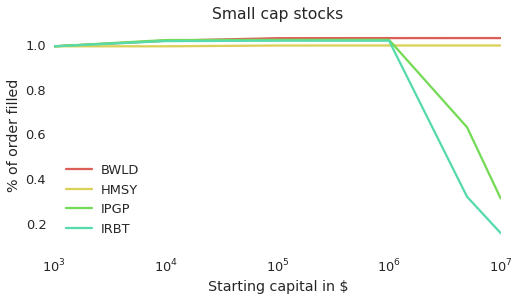

In [203]:
plt.figure(figsize=(8, 4))
# ax1 = plt.subplot(2, 1, 1)
# txn = {}
# for i, test_val in enumerate(test_vals):
#     txn[test_val] = pd.Series({p['sid']: p['amount'] for p in perfs_lc[i].transactions.iloc[30]})
    
# txns = pd.concat(txn).unstack()
# txns /= txns.iloc[0]
# df = pd.DataFrame((np.asarray(txns).T / (np.asarray(txns.index).T / 1000.)).T, columns=txns.columns, index=txns.index)
# df /= df.iloc[0]
# df.plot(ax=ax1, logx=True)
# #plt.xlabel('Starting capital in $')
# plt.ylabel('% of order filled')
# plt.title('Large cap stocks')
# ax1.set_xticks([])

ax2 = plt.subplot(1, 1, 1)
txn = {}
for i in range(len(test_vals)):
    #factor = 10**i
    txn[test_vals[i]] = pd.Series({p['sid']: p['amount'] for p in perfs_sc[i].transactions.iloc[30]})
    
txns = pd.concat(txn).unstack()
txns /= txns.iloc[1]
df = pd.DataFrame((np.asarray(txns).T / (np.asarray(txns.index).T / 1000.)).T, columns=txns.columns, index=txns.index)
df /= df.iloc[0]
df.plot(ax=ax2, logx=True)
plt.xlabel('Starting capital in $')
plt.ylabel('% of order filled')
plt.title('Small cap stocks')
plt.savefig('cap_filled.png')

In [194]:
df = pd.DataFrame((np.asarray(txns).T / (np.asarray(txns.index).T / 1000.)).T, columns=txns.columns, index=txns.index)
df 

,BWLD,HMSY,IPGP,IRBT
1000,1.000000,1.000000,1.0000,1.000000
10000,1.025000,1.000000,1.0280,1.023333
100000,1.036250,1.003478,1.0288,1.025000
500000,1.036750,1.003652,1.0288,1.025000
1000000,1.036750,1.003652,1.0288,1.025000
5000000,1.036825,1.003652,0.6372,0.326000
10000000,1.036825,1.003652,0.3186,0.163000


In [131]:
def orders_to_df(perf):
    def extract_order_info(orders):
        if len(orders) == 0:
            return np.nan
        return {order['sid']: order['amount'] for order in orders}

    orders_tmp = perf.orders.apply(extract_order_info).dropna()
    orders = pd.DataFrame(orders_tmp.tolist()).fillna(0)
    orders.index = orders_tmp.index
    orders.index = orders.index.tz_localize('utc')
    orders.index = [pd.tslib.normalize_date(idx) for idx in orders.index]
    
    return orders

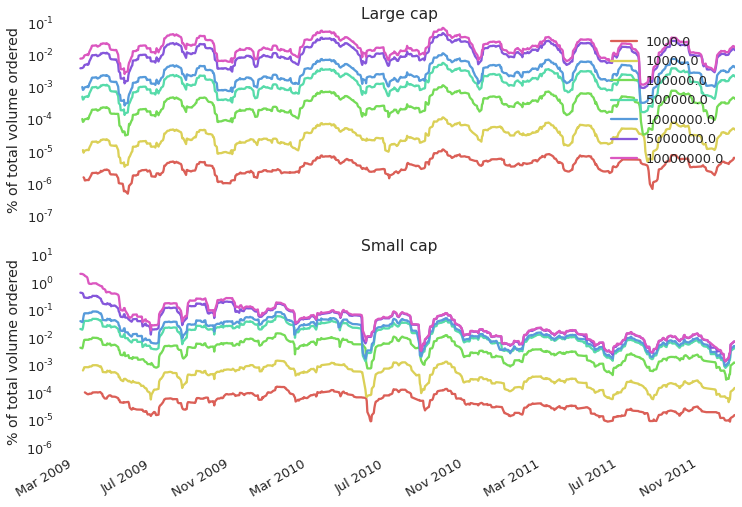

In [206]:
ax1 = plt.subplot(2, 1, 1)
for val, perf in zip(test_vals, perfs_lc):
    df = pd.rolling_mean((orders_to_df(perf) / large_cap.loc[:, :, 'volume']).dropna().abs().max(axis=1), 20)
    df.plot(ax=ax1, label=val, logy=True)
plt.legend()
plt.title('Large cap')
plt.ylabel('% of total volume ordered')
ax1.set_xticks([])

ax2 = plt.subplot(2, 1, 2)
for val, perf in zip(test_vals, perfs_sc):
    df = pd.rolling_mean((orders_to_df(perf) / small_cap.loc[:, :, 'volume']).dropna().abs().max(axis=1), 20)
    df.plot(ax=ax2, label=val, logy=True)
plt.title('Small cap')
plt.ylabel('% of total volume ordered')
plt.tight_layout()
plt.savefig('cap_perc_vol.png')